# Louisville Kentucky Fire Calls

Example project for Code Louisville Data Analysis 1 class.

## Summary

This project uses data from 
[Louisville Metro Open Data](https://data.louisvilleky.gov/) to chart the 
number of service calls by fire districts in the Louisville Metro area.

**Hypothesis:** There are fewer emergency calls in the morning (4am - 8am) than there are 
in the evening (4pm - 8pm).


## Data Discovery

Data Source: [Louisville/Jefferson County Fire Districts calls for 
service.](https://www.arcgis.com/sharing/rest/content/items/a7e8d1790a254d96998ca03e8406afa9/data)

Discovery Steps:
1. Load the service call data into a List of Dict objects
1. Print the number of records and the names of the columns
1. Print the values in the HOUR OF field

In [69]:
import csv

fire_data = []
with open('data/Fire_Open_Data.csv') as input_file:
    reader = csv.DictReader(input_file)
    for row in reader:
        fire_data.append(row)


Number of records:

In [70]:
print("{:,}".format(len(fire_data)))

162,064


Columns:

In [71]:
for key in fire_data[0].keys():
    print(key)

AGENCY_NAME
DATE
CREATE
DISPATCH
ENROUTE
ARRIVE
CLEAR
HOUR OF
LOCATION
EVENT TYPE
PRIORITY
FD EVENT NUMBER
ZIP_CODE


Exmple Record:

In [72]:
for key, value in fire_data[0].items():
    print(key + " : " + value)

AGENCY_NAME : Louisville Fire Department
DATE : 08/01/2020
CREATE : 00:00:59
DISPATCH : 00:01:14
ENROUTE : 00:03:16
ARRIVE : 00:06:39
CLEAR : 00:11:58
HOUR OF : 0000
LOCATION : 900 BLOCK OF S 5TH ST
EVENT TYPE : ALARM--Fire Alarm Sounding-Commercial
PRIORITY : 2
FD EVENT NUMBER : LF200024636
ZIP_CODE : 40203


Values in `HOUR OF` field:

In [73]:
from fire_calls_lib import get_unique_values

hours = get_unique_values(fire_data, 'HOUR OF')

for item in hours:
    print(item)

0000
0100
0200
0300
0400
0500
0600
0700
0800
0900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300


## Data Cleaning

Cleaning Steps:
1. Define the times of day (Morning, Day, Evening, Night)
1. Create a new time of day column based on the `HOUR OF` field
1. Create a new day of week column based on the `DATE` field

Define times of day:

In [74]:
morning = ('0500','0600','0700','0800')
day = ('0900','1000','1100','1200','1300','1400','1500','1600','1700','1800')
evening = ('1900','2000','2100','2200')
night = ('2300','0000','0100','0200','0300','0400')

Create calculated time of day column:

In [75]:
for record in fire_data:
    hour_of = record['HOUR OF']
    if hour_of in morning:
        record['TIME_OF_DAY'] = 'morning'
    elif hour_of in day:
        record['TIME_OF_DAY'] = 'day'
    elif hour_of in evening:
        record['TIME_OF_DAY'] = 'evening'
    elif hour_of in night:
        record['TIME_OF_DAY'] = 'night'
    else:
        record['TIME_OF_DAY'] = 'other'


Values in `TIME_OF_DAY` field:

In [76]:
times = get_unique_values(fire_data, 'TIME_OF_DAY')

for item in times:
    print(item)

night
morning
day
evening


Create the calculated DAY_OF_WEEK column:

In [77]:
import datetime

for record in fire_data:
    call_date = record['DATE']
    record['DAY_OF_WEEK'] = datetime.datetime.strptime(call_date, '%m/%d/%Y').strftime('%A')

Values in the `DAY_OF_WEEK` column:

In [78]:
days = get_unique_values(fire_data, 'DAY_OF_WEEK')

for item in days:
    print(item)

Saturday
Sunday
Monday
Tuesday
Wednesday
Thursday
Friday


## Data Analysis

Which time of day has the most fire service calls?

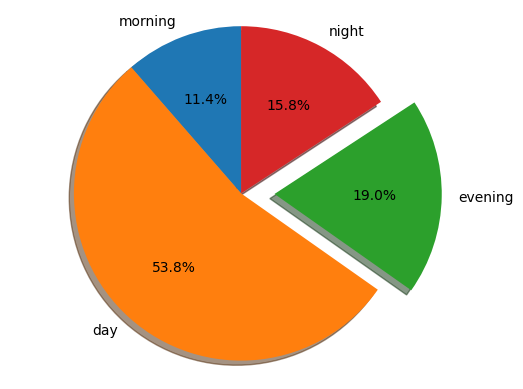

In [79]:
import matplotlib.pyplot as plt
from fire_calls_lib import count_values

calls_by_time_of_day = count_values(fire_data, 'TIME_OF_DAY')

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'morning', 'day', 'evening', 'night'
sizes = [calls_by_time_of_day['morning'], 
        calls_by_time_of_day['day'], 
        calls_by_time_of_day['evening'], 
        calls_by_time_of_day['night']]
explode = (0, 0, 0.2, 0)  # only "explode" the 3rd slice (i.e. 'evening')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

How many morning and evening calls happen each day of the week?

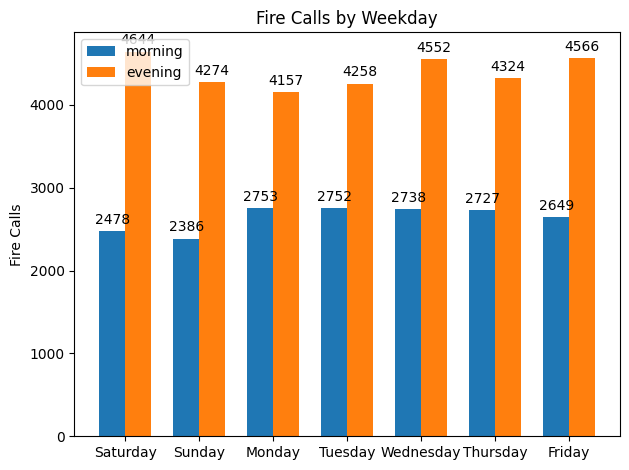

In [80]:
import matplotlib.pyplot as plt
import numpy as np
from fire_calls_lib import count_values_by_date

dates = get_unique_values(fire_data, 'DAY_OF_WEEK')
morning_counts = {}
evening_counts = {}

for record in fire_data:    
    day_of_week = record['DAY_OF_WEEK']
    time_of_day = record['TIME_OF_DAY']
    if time_of_day == 'morning':
        if day_of_week in morning_counts:
            morning_counts[day_of_week] += 1
        else:
            morning_counts[day_of_week] = 1
    elif time_of_day == 'evening':
        if day_of_week in evening_counts:
            evening_counts[day_of_week] += 1
        else:
            evening_counts[day_of_week] = 1

x = np.arange(len(dates))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()

rects1 = ax.bar(x - width/2, list(morning_counts.values()), width, label='morning')
rects2 = ax.bar(x + width/2, list(evening_counts.values()), width, label='evening')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Fire Calls')
ax.set_title('Fire Calls by Weekday')
ax.set_xticks(x, dates)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

## Insights

There are more fire services calls in the evening (19%) than there are in the morning (11.4%). 

Morning calls are less frequent on Saturday and Sunday while evening calls are more frequent on Friday and Saturday.

Evening calls are more frequent than morning calls every day of the week.

## Next Steps

Further analysis could be done by looking at day of week, type of call (fire, medical, etc.) or zip code.

It could be good to look more closely at Wednesday evening calls as they do not match the typical weekday/weekend pattern.